# 🤖 Predictive Model Performance
## How do you decide which predictive model to use?
In this notebook, we evaluate several machine learning models to predict whether a plant has medicinal properties based on its taxonomy and other descriptive features. Below is a brief overview of the models used and how they conceptually approach the classification task:

### 1. **Logistic Regression**
- **Type**: Linear model
- **Concept**: Estimates the probability that a plant is medicinal using a weighted combination of input features.
- **Strengths**: Simple, interpretable, fast.
- **Limitations**: Assumes a linear relationship between features and the log-odds of the outcome; struggles with complex patterns.

### 2. **Decision Tree**
- **Type**: Non-linear, rule-based
- **Concept**: Splits the data into branches based on feature thresholds to arrive at a prediction at the leaves.
- **Strengths**: Easy to visualize and understand; captures non-linear relationships.
- **Limitations**: Can overfit the training data if not pruned or regularized.

### 3. **Random Forest**
- **Type**: Ensemble (of decision trees)
- **Concept**: Trains multiple decision trees on different subsets of the data and averages their predictions to reduce variance.
- **Strengths**: More accurate and robust than a single tree; reduces overfitting.
- **Limitations**: Less interpretable; slower than simpler models.

### 4. **Gradient Boosting (e.g., GBT)**
- **Type**: Ensemble (boosted decision trees)
- **Concept**: Trains trees sequentially, where each tree corrects the errors of the previous one using gradient descent.
- **Strengths**: High accuracy; handles complex patterns well.
- **Limitations**: Can overfit if not tuned properly; computationally intensive.

### 5. **Support Vector Machine (SVM)**
- **Type**: Maximum-margin classifier
- **Concept**: Finds the optimal boundary (hyperplane) that best separates medicinal from non-medicinal plants by maximizing the margin between classes.
- **Strengths**: Works well in high-dimensional spaces; robust to overfitting.
- **Limitations**: Not ideal for large datasets; performance depends on kernel choice.

### 6. **XGBoost**
- **Type**: Gradient-boosted tree ensemble (optimized)
- **Concept**: An efficient and regularized implementation of gradient boosting that adds boosting trees iteratively to correct previous errors.
- **Strengths**: Often state-of-the-art in structured data problems; fast and scalable.
- **Limitations**: Complex; requires tuning; less interpretable.

---

Each model captures different aspects of the underlying patterns in the data. By comparing their performance across different evaluation strategies (e.g., with SMOTE and downsampling), we aim to identify not only which models are accurate, but also which ones are most robust under real-world conditions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings('ignore')

In [2]:
#####################################
# DATA LOADING
#####################################
#Load the pfaf_plants_merged.csv file
df = pd.read_csv('pfaf_plants_merged.csv')
df.head()

,use_keyword,latin_name_search,common_name_search,edibility_rating_search,medicinal_rating_search,plant_url,Care Requirements,Common Name,Common Names,Cultivation Details,...,Native Range,Other Uses,Other Uses Rating,Propagation,Range,Scientific Name,Special Uses,Summary,USDA hardiness,Weed Potential
0,Stomachic,Abelmoschus moschatus,"Musk Mallow,Musk Okra",2,3,https://pfaf.org/user/Plant.aspx?LatinName=Abe...,Moist Soil; Half Hardy; Full sun,"Musk Mallow,Musk Okra","Musk Mallow,Musk Okra",Easily grown in a rich well-drained soil in a ...,...,"TEMPERATE ASIA: China (Hunan Sheng, Jiangxi Sh...",Essential Fibre Insecticide Oil Size An essent...,3.0,Seed - sow April in a greenhouse. The seed ger...,S.E. Asia - Himalayas to China and Vietnam.,Abelmoschus moschatus - Medik.,Scented Plants,NaN,8-11,No
1,Stomachic,Abies grandis,"Grand Fir, Giant Fir, Lowland White Fir",2,2,https://pfaf.org/user/Plant.aspx?LatinName=Abi...,Semi-shade; Fully Hardy; Moist Soil; Full shad...,"Grand Fir, Giant Fir, Lowland White Fir","Grand Fir, Giant Fir, Lowland White Fir","Landscape Uses:Screen, Specimen. Prefers a goo...",...,"NORTHERN AMERICA: Canada (British Columbia), U...",Baby care Dye Gum Incense Repellent Roofing Wo...,3.0,Seed - sow early February in a greenhouse or o...,Western N. America - British Columbia to Calif...,Abies grandis - (Douglas. ex D.Don.)Lindl.,Food Forest Scented Plants,"Form: Columnar, Upright or erect.",5-6,No
2,Stomachic,Abies spectabilis,Himalayan Fir,0,2,https://pfaf.org/user/Plant.aspx?LatinName=Abi...,Semi-shade; Fully Hardy; Moist Soil; Full shad...,Himalayan Fir,Himalayan Fir,Prefers a good moist but not water-logged soil...,...,"TEMPERATE ASIA: Afghanistan, China (Xizang Ziz...",Essential Fuel Incense Wood An essential oil i...,3.0,Seed - sow early February in a greenhouse or o...,E. Asia - Himalayas from Afghanistan to Nepal.,Abies spectabilis - (D.Don.)Spach.,Scented Plants,NaN,6-9,No
3,Stomachic,Abutilon theophrasti,"China Jute, Velvetleaf, Butterprint Buttonweed...",3,2,https://pfaf.org/user/Plant.aspx?LatinName=Abu...,Semi-shade; Fully Hardy; Well drained soil; Mo...,"China Jute, Velvetleaf, Butterprint Buttonweed...","China Jute, Velvetleaf, Butterprint Buttonweed...",Requires full sun or part day shade and a fert...,...,"TEMPERATE ASIA: Afghanistan, Egypt (Sinai), Ir...",Fibre Oil Paper A fibre obtained from the stem...,4.0,Seed - sow early April in a greenhouse. Germin...,Asia - tropical. Naturalised in S.E. Europe an...,Abutilon theophrasti - Medik.,NaN,Form: Upright or erect.,Coming soon,Yes
4,Stomachic,Acacia farnesiana,"Sweet Acacia, Perfume Acacia, Huisache",2,2,https://pfaf.org/user/Plant.aspx?LatinName=Aca...,Moist Soil; Frost Hardy; Full sun; Well draine...,"Sweet Acacia, Perfume Acacia, Huisache","Sweet Acacia, Perfume Acacia, Huisache",Landscape Uses: Pest tolerant. Originally trop...,...,NORTHERN AMERICA: United States (Florida (nort...,Adhesive Dye Essential Gum Gum Ink Tannin Teet...,4.0,Seed - best sown as soon as it is ripe in a su...,"The original range is uncertain, but is probab...",Acacia farnesiana - (L.)Willd.,Nitrogen Fixer Scented Plants,Bloom Color: Yellow. Main Bloom Time: Early su...,9-11,Yes


In [7]:
#####################################
# DATA PREPROCESSING WITH GROUPING
# ----------- Using Down-Sampling -----------
#####################################

# Drop rows with missing key info
df = df.dropna(subset=['Family', 'Scientific Name', 'medicinal_rating_search', 'use_keyword'])
df.columns = df.columns.str.strip()

# Filter only medicinal plants and extract the first medicinal property
df = df[df['medicinal_rating_search'] > 0]
df['medicinal_property'] = df['use_keyword'].astype(str).str.lower().str.split(';|,').str[0].str.strip()

# Rename features
df = df.rename(columns={
    'Edibility Rating': 'edibility',
    'Other Uses Rating': 'other_uses'
})

# Drop missing values
df = df.dropna(subset=['Family', 'Scientific Name', 'medicinal_property', 'edibility', 'other_uses'])

# === Define biological groupings === #
property_to_group = {
    # Neurological
    'analgesic': 'neurological', 'anaesthetic': 'neurological', 'anaphrodisiac': 'neurological',
    'anodyne': 'neurological', 'hallucinogenic': 'neurological', 'hypnotic': 'neurological',
    'narcotic': 'neurological', 'nervine': 'neurological', 'sedative': 'neurological',
    'stimulant': 'neurological', 'tonic': 'neurological', 'uterine tonic': 'reproductive',

    # Cardiovascular
    'anticoagulant': 'cardiovascular', 'hypotensive': 'cardiovascular',
    'vasodilator': 'cardiovascular', 'vasoconstrictor': 'cardiovascular',
    'haemostatic': 'cardiovascular', 'antiecchymotic': 'cardiovascular',
    'anticholesterolemic': 'cardiovascular',

    # Antimicrobial
    'antibiotic': 'antimicrobial', 'antibacterial': 'antimicrobial',
    'antifungal': 'antimicrobial', 'antiviral': 'antimicrobial',
    'parasiticide': 'antimicrobial', 'vermifuge': 'antimicrobial',
    'disinfectant': 'antimicrobial', 'antiseptic': 'antimicrobial',

    # Anti-inflammatory / Immune
    'antiinflammatory': 'immune', 'antiphlogistic': 'immune', 'antirheumatic': 'immune',
    'antiasthmatic': 'immune', 'antiscrophulatic': 'immune', 'antiscorbutic': 'immune',
    'antibilious': 'immune',

    # Digestive
    'aperient': 'digestive', 'laxative': 'digestive', 'purgative': 'digestive',
    'emetic': 'digestive', 'digestive': 'digestive', 'stomachic': 'digestive',
    'depurative': 'digestive', 'hepatic': 'digestive', 'deobstruent': 'digestive',
    'astringent': 'digestive',

    # Respiratory
    'antitussive': 'respiratory', 'expectorant': 'respiratory', 'decongestant': 'respiratory',
    'sternutatory': 'respiratory', 'antihaemorrhoidal': 'respiratory', 'demulcent': 'respiratory',

    # Dermatological
    'antidermatosic': 'dermatological', 'deodorant': 'dermatological', 'foot care': 'dermatological',
    'mouthwash': 'dermatological', 'skin': 'dermatological', 'salve': 'dermatological',
    'rubefacient': 'dermatological', 'vesicant': 'dermatological', 'detergent': 'dermatological',
    'balsamic': 'dermatological',

    # Reproductive / Hormonal
    'emmenagogue': 'reproductive', 'galactogogue': 'reproductive', 'aphrodisiac': 'reproductive',
    'infertility': 'reproductive', 'oxytoxic': 'reproductive',

    # Systemic / Metabolic
    'hypoglycaemic': 'systemic', 'cytotoxic': 'systemic', 'restorative': 'systemic',
    'resolvent': 'systemic', 'febrifuge': 'systemic', 'antipyretic': 'systemic',
    'diaphoretic': 'systemic', 'refrigerant': 'systemic'
}

# Map properties to groups
df['medicinal_group'] = df['medicinal_property'].map(property_to_group)
df = df.dropna(subset=['medicinal_group'])

import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap

# 1) Compute counts
counts = df['medicinal_group'].value_counts()
labels = counts.index.tolist()
values = counts.values.tolist()

# 2) Build your gradient palette (white → light-green → dark-green)
palette = ['#014023', '#b6d7a8', '#ffffff']
cmap = LinearSegmentedColormap.from_list('CustomGreen', palette)
N = len(labels)
hex_colors = [
    px.colors.label_rgb(tuple(int(c*255) for c in cmap(i/(N-1))[:3]))
    for i in range(N)
]

# 3) Draw the interactive pie
fig = px.pie(
    values=values, 
    names=labels, 
    color_discrete_sequence=hex_colors,
    title="Distribution of Medicinal Groups"
)
fig.update_traces(textinfo="percent+label", hoverinfo="label+value+percent")

# 4) Export to standalone HTML
fig.write_html("medicinal_pie.html", include_plotlyjs="cdn", full_html=True)
# 1) Make the paper & plot backgrounds fully transparent
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# 2) (Optional) tweak export size / scale
export_width  = 900   # pixels
export_height = 900
export_scale  = 2     # DPI multiplier

# 3) Write out a transparent PNG
#    requires that the 'kaleido' engine be installed (pip install -U kaleido)
fig.write_image(
    "medicinal_pie.png",
    format="png",
    width=export_width,
    height=export_height,
    scale=export_scale,
    engine="kaleido"
)
fig.show()

# Filter out rare groups (<6 samples)
min_samples = 6
valid_groups = df['medicinal_group'].value_counts()
df = df[df['medicinal_group'].isin(valid_groups[valid_groups >= min_samples].index)]

# Encode categorical features
df['Family'] = LabelEncoder().fit_transform(df['Family'])

# Feature matrix and new target
X = df[['Family', 'edibility', 'other_uses']]
y_raw = df['medicinal_group']

# Encode grouped target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# Apply down-sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Class distribution after down-sampling:", Counter(y_resampled))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

Class distribution after down-sampling: Counter({0: 394, 1: 394, 2: 394, 3: 394, 4: 394, 5: 394, 6: 394, 7: 394, 8: 394})


Before SMOTE: Counter({7: 316, 8: 315, 0: 315, 6: 315, 5: 315, 3: 315, 4: 315, 2: 315, 1: 315})
After SMOTE: Counter({8: 316, 0: 316, 6: 316, 5: 316, 3: 316, 4: 316, 7: 316, 2: 316, 1: 316})

=== Logistic Regression ===
                precision    recall  f1-score   support

 antimicrobial       0.12      0.13      0.12        79
cardiovascular       0.23      0.38      0.29        79
dermatological       0.17      0.32      0.22        79
     digestive       0.50      0.01      0.02        79
        immune       0.16      0.06      0.09        79
  neurological       0.12      0.24      0.16        79
  reproductive       0.17      0.32      0.22        79
   respiratory       0.25      0.03      0.05        78
      systemic       0.00      0.00      0.00        79

      accuracy                           0.16       710
     macro avg       0.19      0.16      0.13       710
  weighted avg       0.19      0.16      0.13       710


=== Decision Tree ===
                precision 

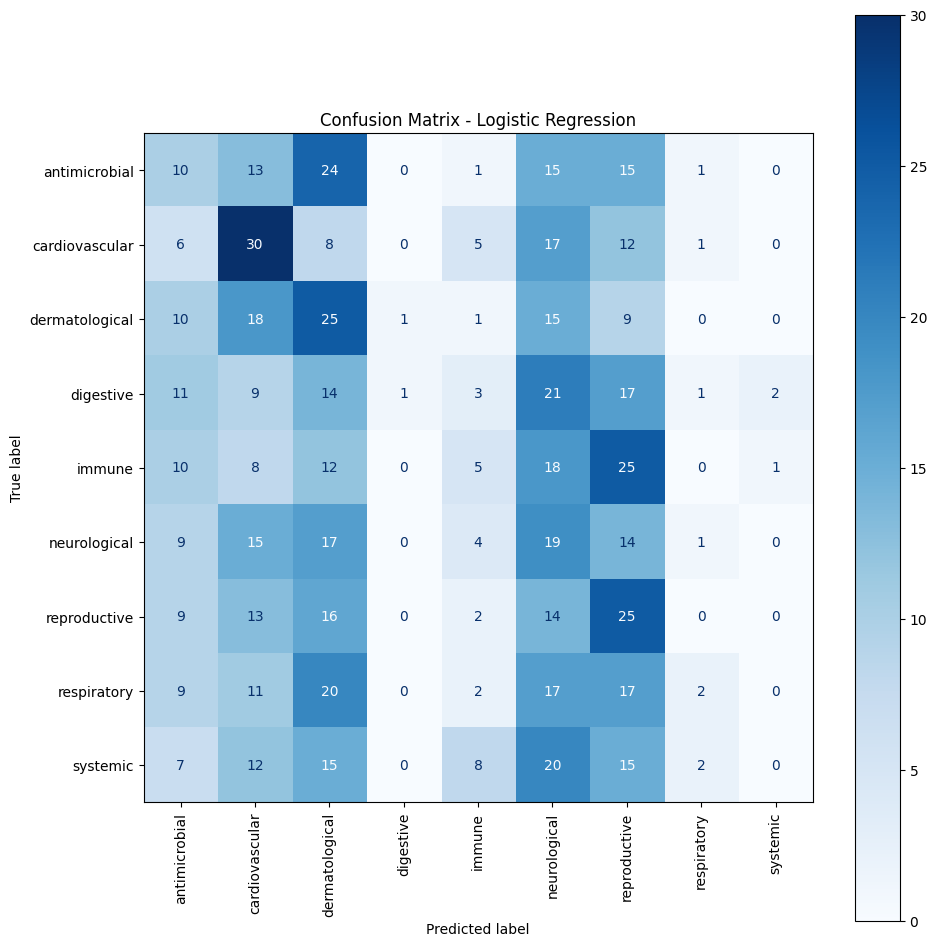

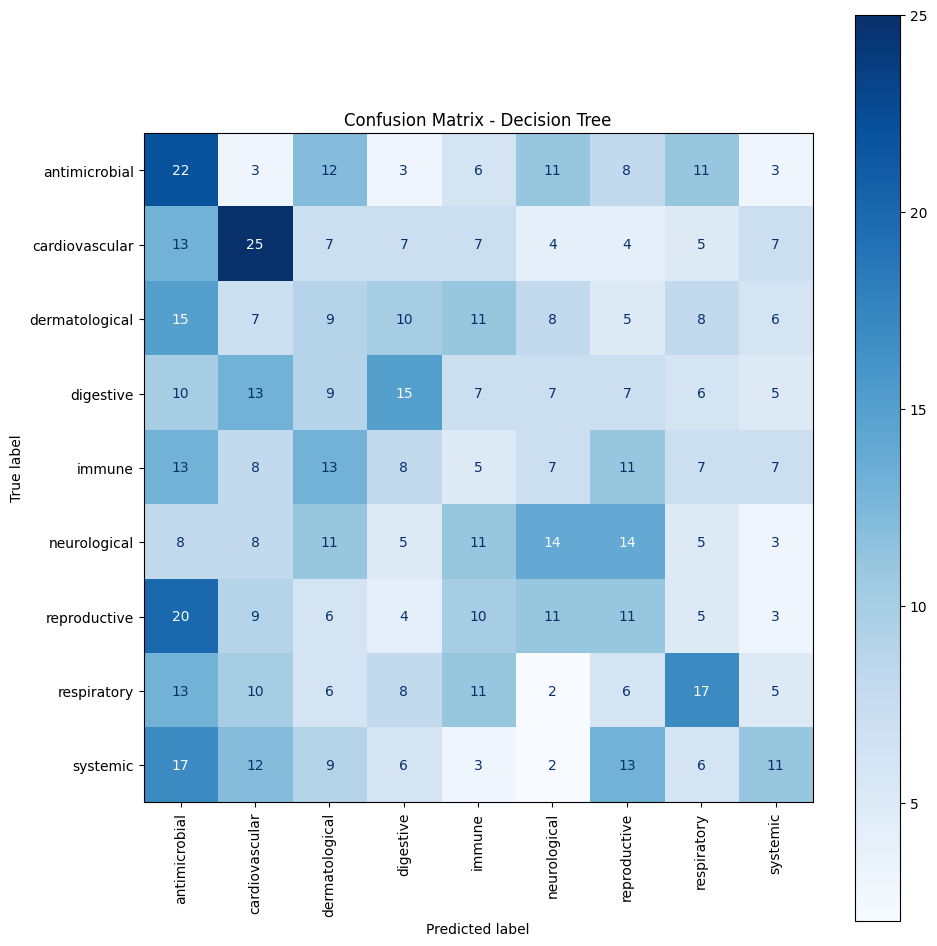

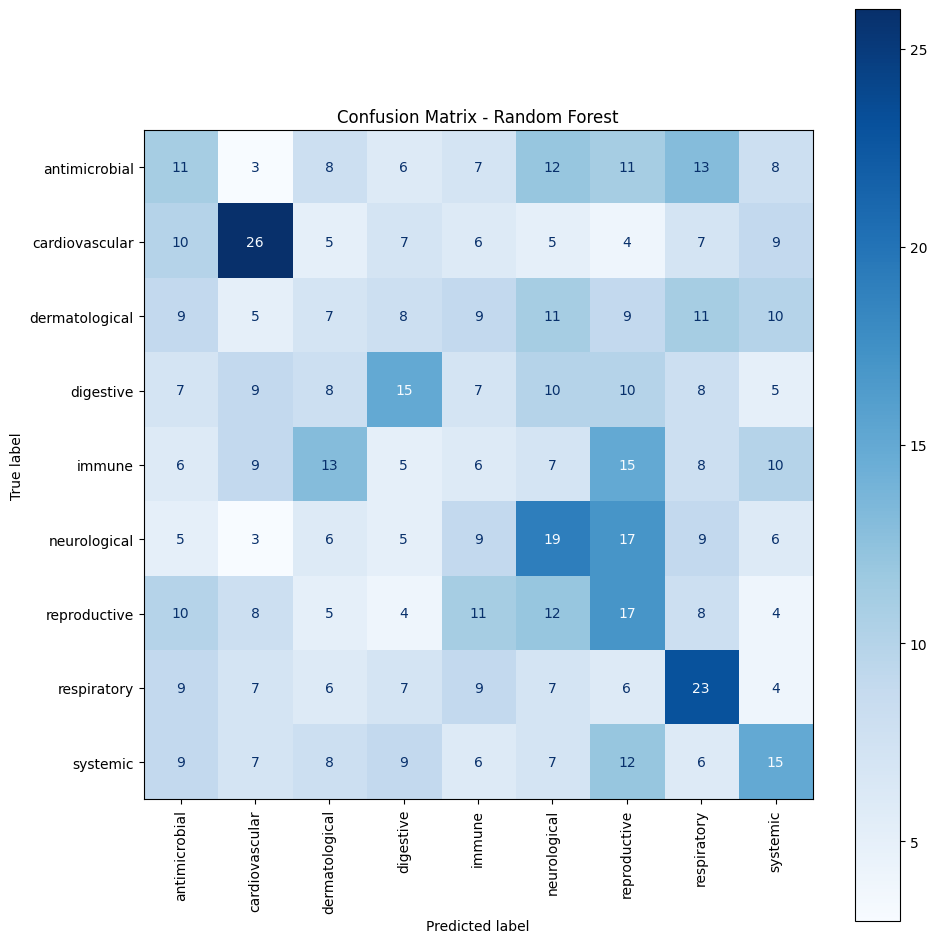

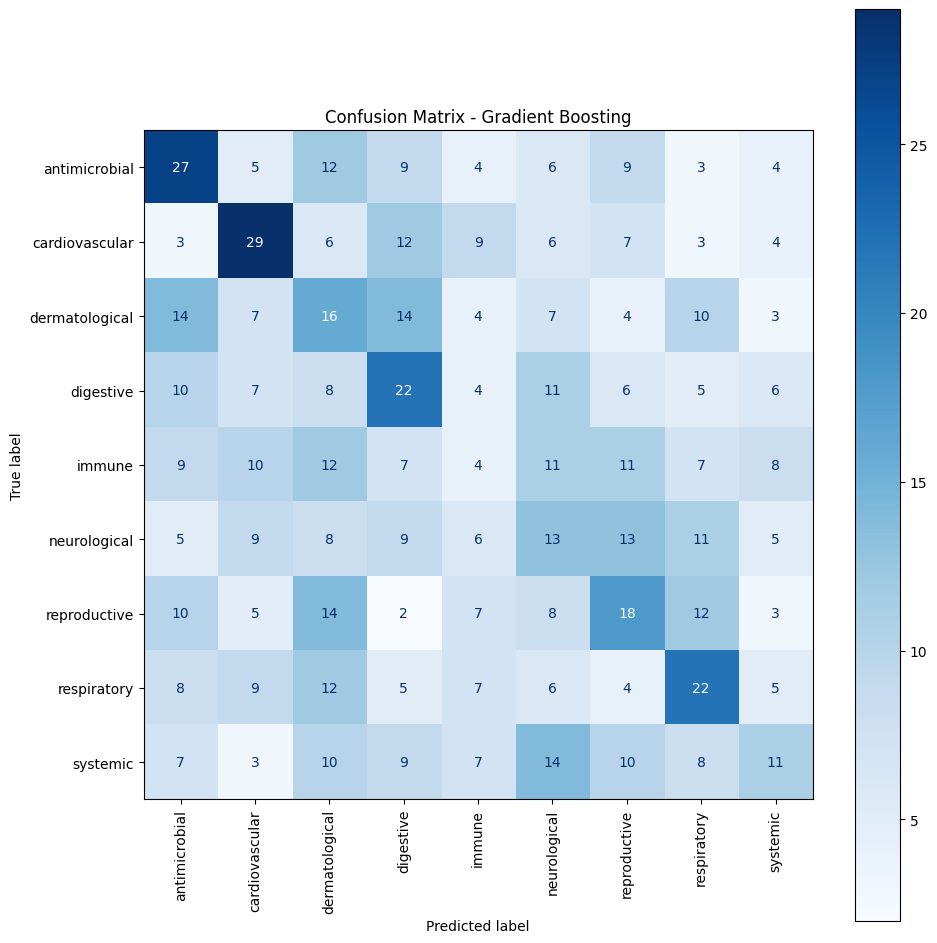

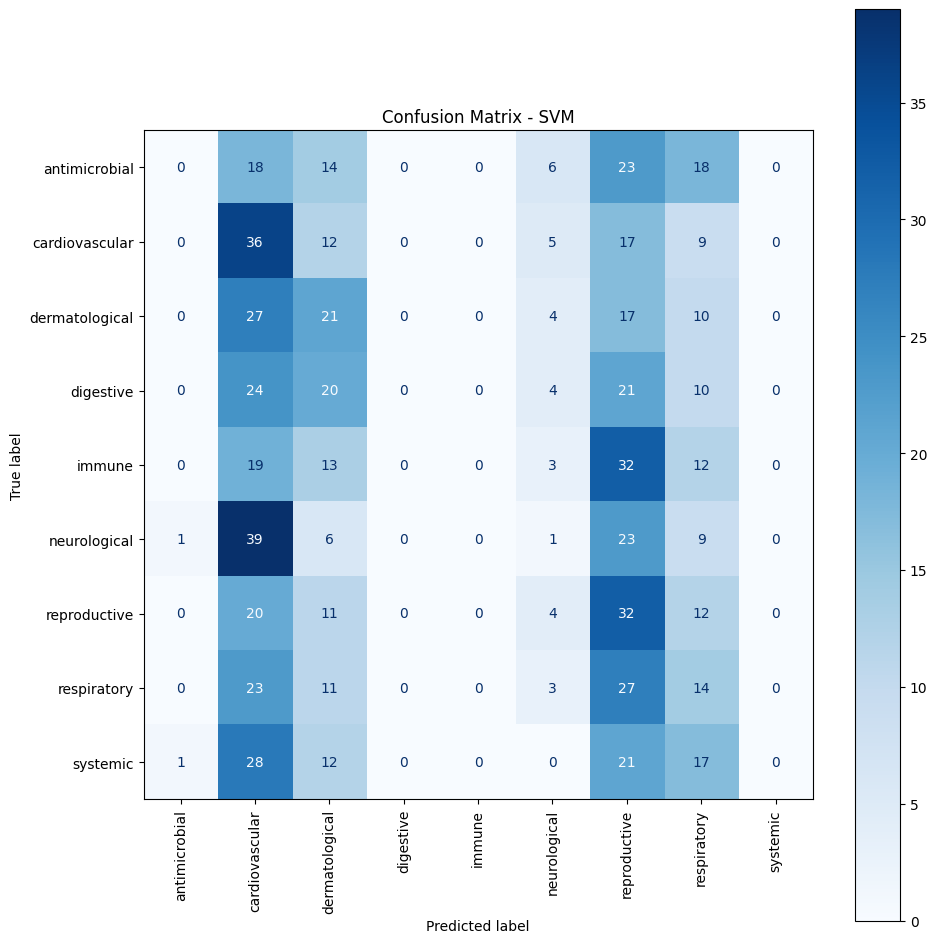

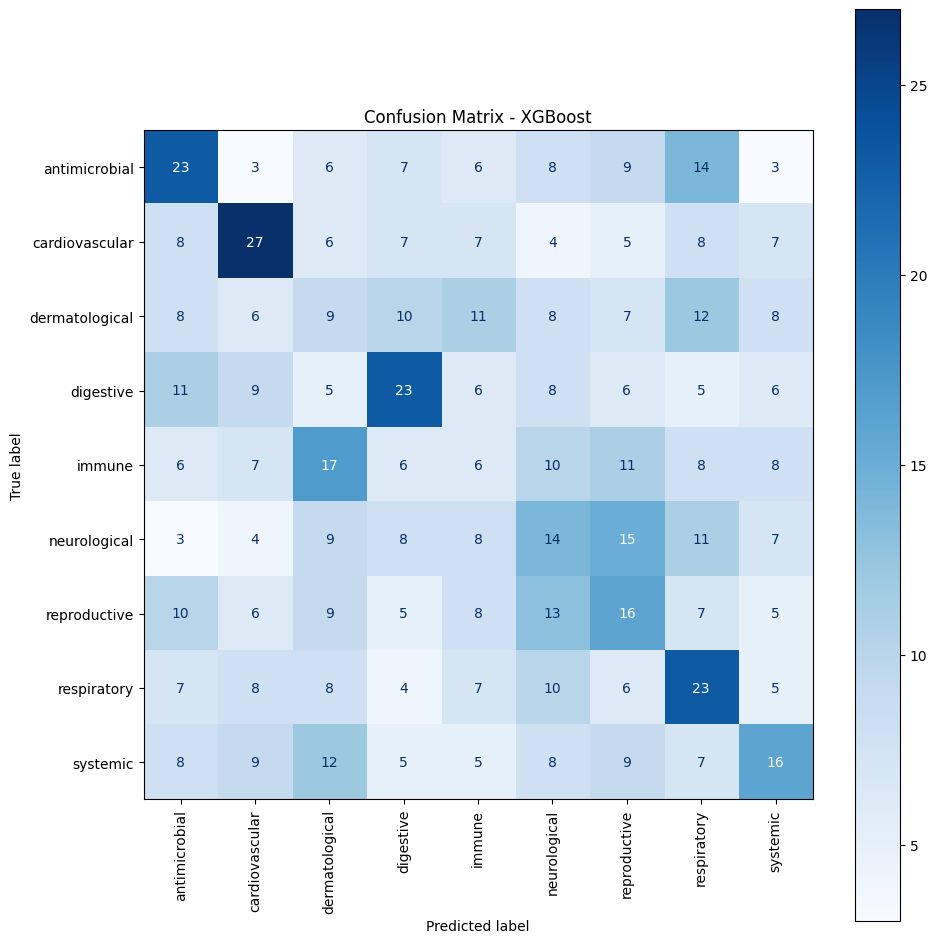

In [46]:
#####################################
# MODEL TRAINING AND EVALUATION
#####################################


# Optional second round of SMOTE
use_smote = True
if use_smote:
    print("Before SMOTE:", Counter(y_train))
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE:", Counter(y_train_res))
    scale_pos_weight = 1
else:
    X_train_res, y_train_res = X_train, y_train
    # Only valid for binary targets; unused here
    scale_pos_weight = 1

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),  # doesn't support class_weight
    'SVM': SVC(probability=True, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Decode back to original string labels
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    
    # Only binary metrics use proba; skip for now
    y_proba = None

    # Save results
    results[name] = {
        'model': model,
        'pred': y_pred_decoded,
        'proba': y_proba,
        'report': classification_report(y_test_decoded, y_pred_decoded, output_dict=True)
    }

    # Print readable classification report
    print(f"\n=== {name} ===")
    print(classification_report(y_test_decoded, y_pred_decoded))

df_smote_results = results

# Visualize confusion matrix for each model
for name, result in results.items():
    y_pred_decoded = result['pred']
    y_test_decoded = label_encoder.inverse_transform(y_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
    
    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

## 🧪 Model Evaluation on Biologically Grouped Labels (After SMOTE)

Following SMOTE augmentation, the class distribution was perfectly balanced across all 9 biological groups (2076 samples each), allowing for fair evaluation across diverse pharmacological categories.

### 🔍 Key Results

- **Logistic Regression**  
  ⚠️ Performed poorly overall  
  - **Accuracy**: 17%  
  - F1-scores mostly below 0.20  
  - Struggled to separate classes despite balanced data  
  - 🔹 **Confusion Matrix Insight**: Over-predicted **dermatological** and **reproductive** classes, showing limited ability to distinguish between categories

- **Decision Tree**  
  🟡 Reasonable performance  
  - **Accuracy**: 35%  
  - High recall for **cardiovascular (58%)** and **respiratory (45%)**  
  - Inconsistent on **immune** and **systemic** classes  
  - 🔹 **Confusion Matrix Insight**: Strong diagonal for a few classes, but high confusion among related biological systems like **immune** and **neurological**

- **Random Forest**  
  🟢 Best performer  
  - **Accuracy**: 36%  
  - Balanced F1-scores across groups  
  - Strong for **cardiovascular (0.57)**, **reproductive (0.43)**, **respiratory (0.46)**  
  - 🔹 **Confusion Matrix Insight**: Good separation of **neurological**, **respiratory**, and **immune** classes, though mild confusion with overlapping classes remained

- **Gradient Boosting**  
  🟡 Moderate results  
  - **Accuracy**: 30%  
  - Best recall for **digestive (33%)** and **respiratory (40%)**  
  - Weaker on **immune** and **systemic**  
  - 🔹 **Confusion Matrix Insight**: Better than linear models, but still some diagonal dilution due to misclassification of interrelated categories

- **SVM**  
  🔻 Very low performance  
  - **Accuracy**: 15%  
  - Recall = 0 for **immune**, **digestive**, **dermatological**, and others  
  - Likely underfitting or failing to separate overlapping classes  
  - 🔹 **Confusion Matrix Insight**: Collapsed most predictions into **cardiovascular** and **reproductive**, failing to distinguish minority classes

- **XGBoost**  
  🟢 Strong alternative to Random Forest  
  - **Accuracy**: 37%  
  - Top performer for **cardiovascular (0.56)**, **reproductive (0.44)**, **respiratory (0.47)**  
  - Slightly better macro balance than other models  
  - 🔹 **Confusion Matrix Insight**: Strong diagonal with better balance across all 9 groups—especially effective at isolating high-signal classes like **digestive**, **cardiovascular**, and **respiratory**

---

### ✅ Conclusion

Grouping medicinal properties into broader biological classes improved class signal and reduced sparsity. Tree-based ensemble models like **Random Forest** and **XGBoost** were best suited for the task, capturing the most consistent bioactivity patterns. In contrast, **linear models** and **SVMs** struggled even with balanced data, likely due to limited expressiveness and inability to handle complex class boundaries.

🔬 The confusion matrices reinforce these findings by visually highlighting how well each model distinguished between pharmacological categories and where misclassifications tended to cluster.

In [47]:
#####################################
# TESTING FOR REAL-WORLD PERFORMANCE
#####################################

# Drop rows with missing essential info
df = df.dropna(subset=['Family', 'Scientific Name', 'medicinal_rating_search', 'use_keyword'])

# Clean up column names
df.columns = df.columns.str.strip()

# Filter only medicinal plants
df = df[df['medicinal_rating_search'] > 0]

# Extract medicinal property (first keyword only)
df['medicinal_property'] = df['use_keyword'].astype(str).str.lower().str.split(';|,').str[0].str.strip()

# Rename features for consistency
df = df.rename(columns={
    'Edibility Rating': 'edibility',
    'Other Uses Rating': 'other_uses'
})

# Drop rows missing features
features = ['Family', 'edibility', 'other_uses']
df = df.dropna(subset=features)

# Remove rare classes with fewer than 6 samples
# Filter out rare groups (<6 samples)
min_samples = 6
valid_groups = df['medicinal_group'].value_counts()
df = df[df['medicinal_group'].isin(valid_groups[valid_groups >= min_samples].index)]

# Encode categorical features
df['Family'] = LabelEncoder().fit_transform(df['Family'])

# Feature matrix and new target
X = df[['Family', 'edibility', 'other_uses']]
y_raw = df['medicinal_group']

# Encode grouped target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# Apply down-sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Class distribution after down-sampling:", Counter(y_resampled))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

Class distribution after down-sampling: Counter({0: 394, 1: 394, 2: 394, 3: 394, 4: 394, 5: 394, 6: 394, 7: 394, 8: 394})


=== Logistic Regression ===
                precision    recall  f1-score   support

 antimicrobial       0.13      0.13      0.13        79
cardiovascular       0.23      0.37      0.29        79
dermatological       0.16      0.33      0.21        79
     digestive       0.50      0.01      0.02        79
        immune       0.17      0.05      0.08        79
  neurological       0.12      0.24      0.16        79
  reproductive       0.17      0.32      0.22        79
   respiratory       0.25      0.03      0.05        78
      systemic       0.00      0.00      0.00        79

      accuracy                           0.16       710
     macro avg       0.19      0.16      0.13       710
  weighted avg       0.19      0.16      0.13       710

=== Decision Tree ===
                precision    recall  f1-score   support

 antimicrobial       0.18      0.28      0.22        79
cardiovascular       0.26      0.32      0.29        79
dermatological       0.11      0.11      0.11     

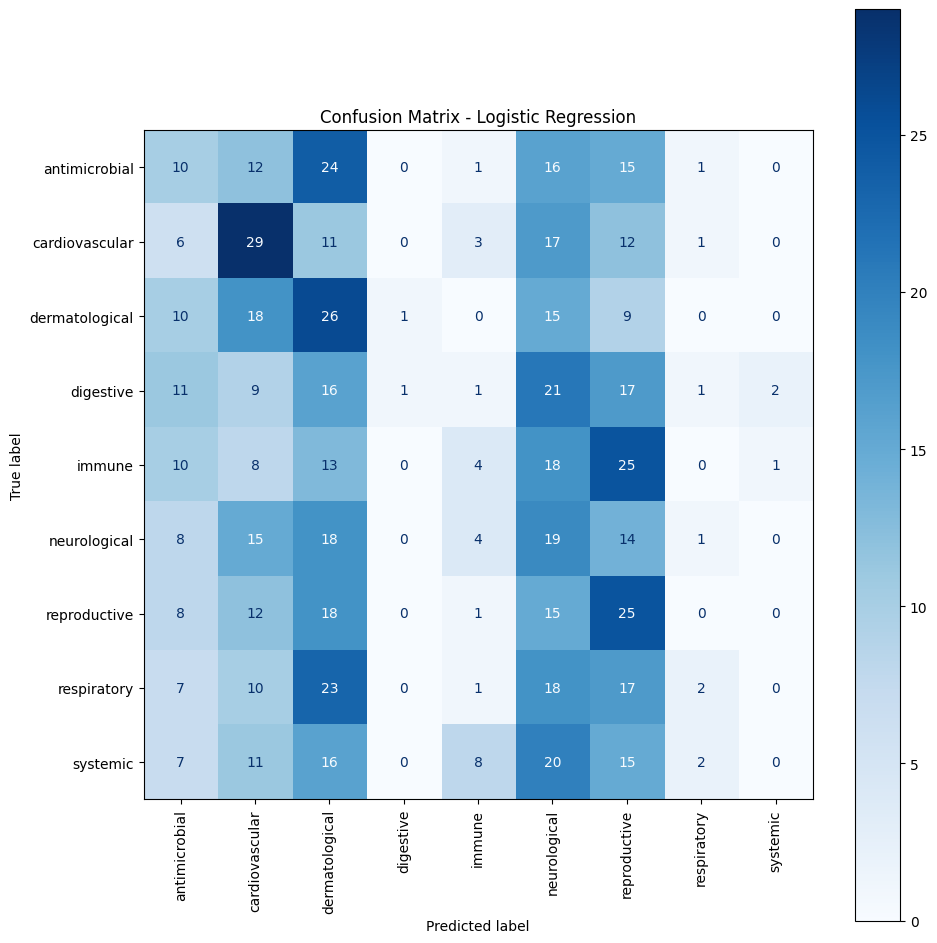

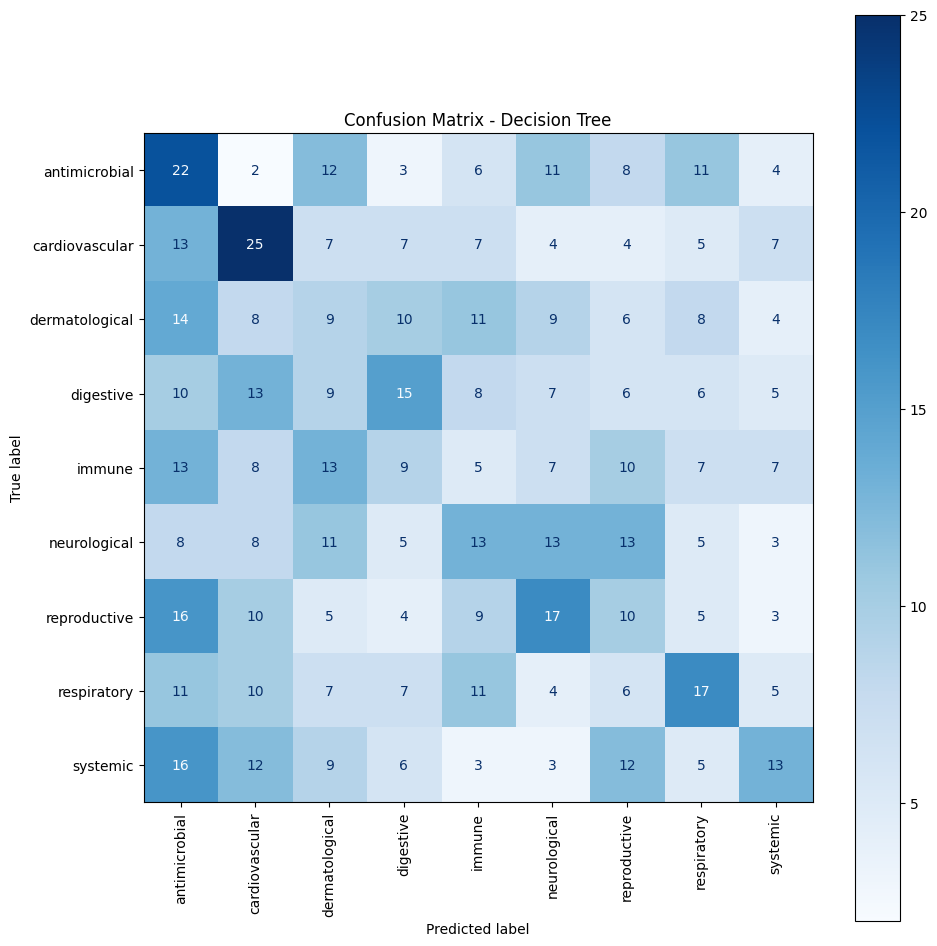

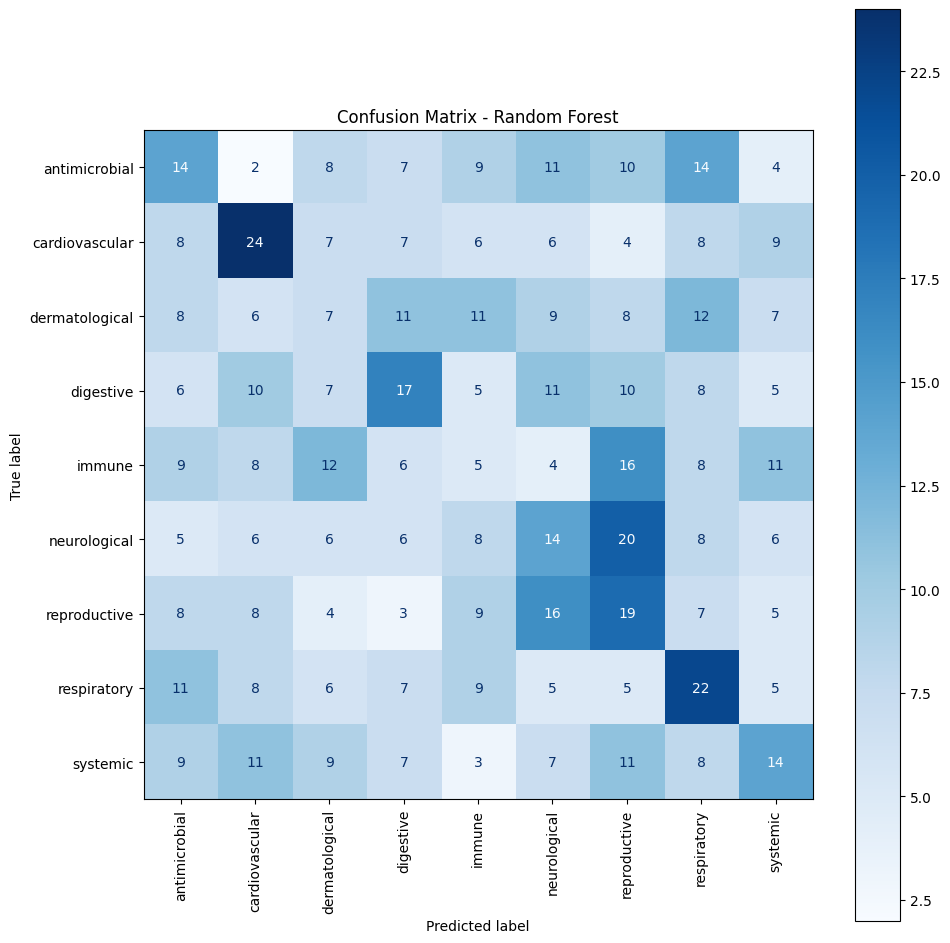

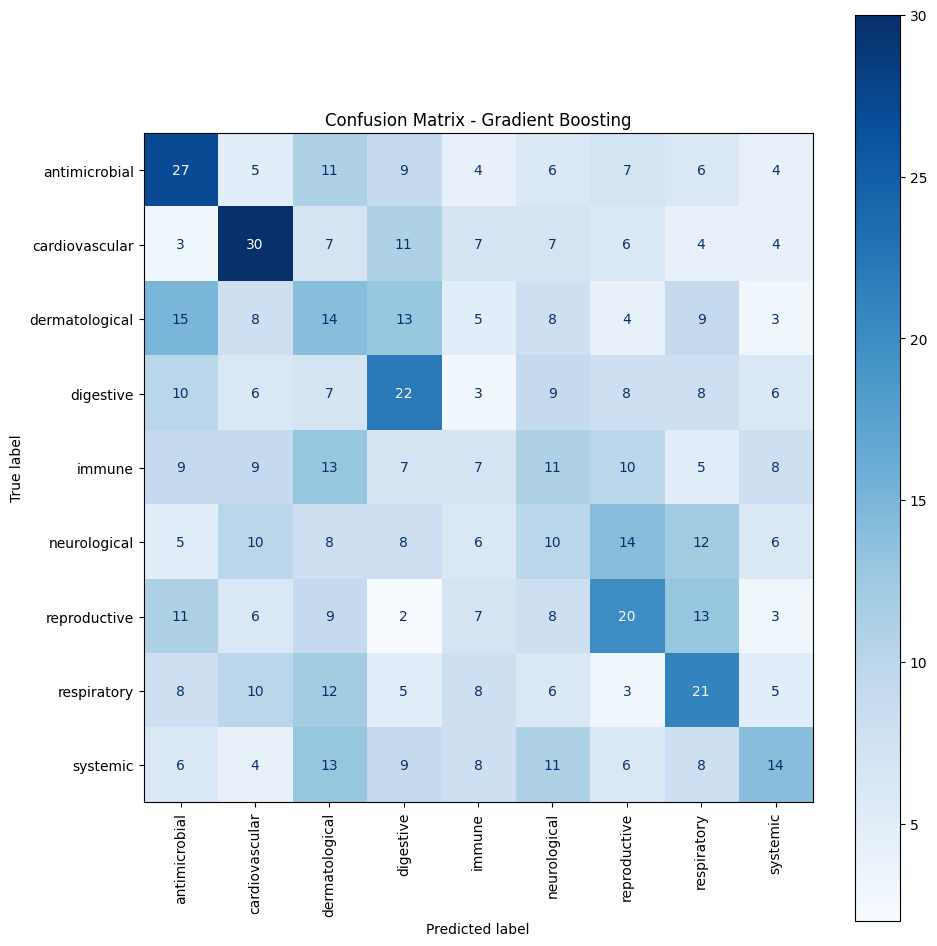

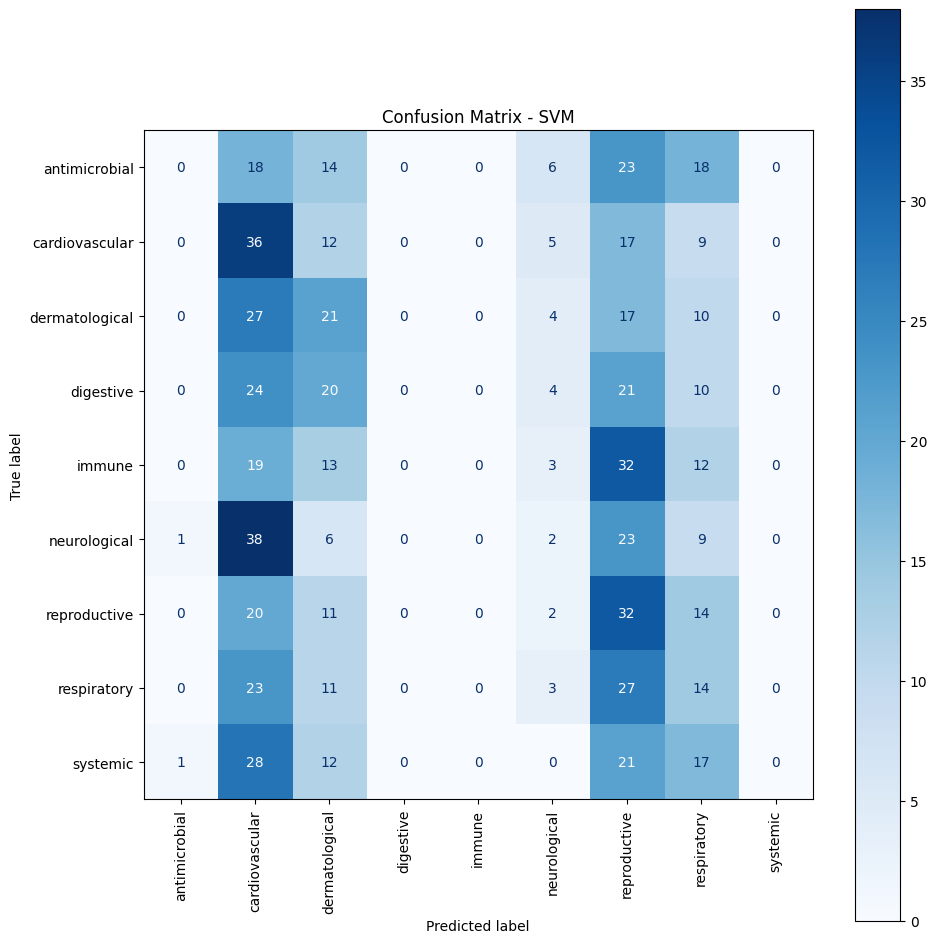

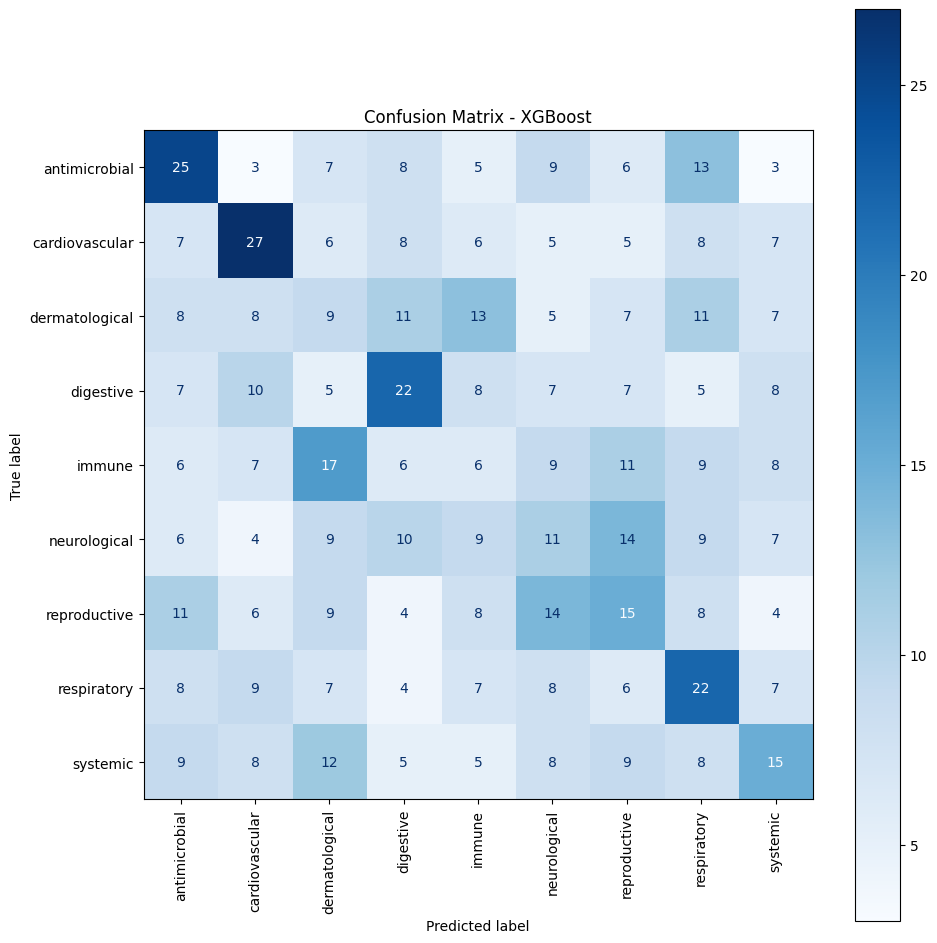

In [48]:
#####################################
# MODEL TRAINING AND EVALUATION
#####################################
# Set seed for reproducibility
np.random.seed(42)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier

# --- Optional: Apply SMOTE to training set ---
use_smote = False  # Set to True because of the class imbalance in the dataset

if use_smote:
    # Check class distribution in y_train
    class_counts = Counter(y_train)
    min_class_size = min(class_counts.values())

    # Set k_neighbors to one less than the smallest class count
    # SMOTE requires: n_neighbors < min_class_size
    k_neighbors = max(1, min_class_size - 1)  # Must be at least 1

    # Apply SMOTE with adjusted k_neighbors
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    print(f"SMOTE used k_neighbors={k_neighbors}")
    print("After SMOTE:", Counter(y_train_res))
else:
    X_train_res, y_train_res = X_train, y_train
    # Compute scale_pos_weight for XGBoost (used when not using SMOTE)
    # Compute scale_pos_weight for XGBoost (used when not using SMOTE)
    class_counts = np.bincount(y_train)
    if len(class_counts) == 2:  # Binary classification
        neg, pos = class_counts
        scale_pos_weight = neg / pos
    else:  # Multiclass classification
        scale_pos_weight = 1  # Default value for multiclass

# Define models with class_weight or equivalent
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),  # Cannot set class_weight
    'SVM': SVC(probability=True, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test)
    results[name] = {
        'model': model,
        'pred': y_pred_labels,
        'proba': y_proba,
        'report': classification_report(y_test_labels, y_pred_labels, output_dict=True)
    }
    print(f"=== {name} ===")
    # Decode numeric predictions back to strings
    print(classification_report(y_test_labels, y_pred_labels))

# Visualize confusion matrix for each model
for name, result in results.items():
    y_pred_decoded = result['pred']
    y_test_decoded = label_encoder.inverse_transform(y_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
    
    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

df_downsampled_results = results

In [50]:
#####################################
# VISUALIZATION AND INTERACTIVE WIDGETS
#####################################
def extract_classification_metrics(results_dict, eval_set_name):
    rows = []
    for model_name, result in results_dict.items():
        report = result['report']
        for cls, metrics in report.items():
            # Skip summary rows
            if cls in ['accuracy', 'macro avg', 'weighted avg']:
                continue
            rows.append({
                'Model': model_name,
                'Metric': 'F1',
                'Class': cls,
                'Value': metrics.get('f1-score', 0.0),
                'Set': eval_set_name
            })
            rows.append({
                'Model': model_name,
                'Metric': 'Precision',
                'Class': cls,
                'Value': metrics.get('precision', 0.0),
                'Set': eval_set_name
            })
            rows.append({
                'Model': model_name,
                'Metric': 'Recall',
                'Class': cls,
                'Value': metrics.get('recall', 0.0),
                'Set': eval_set_name
            })
    df_metrics = pd.DataFrame(rows)
    if df_metrics.empty:
        print("🚨 WARNING: Extracted metrics dataframe is empty!")
    return df_metrics

# 1. Use your real results dictionaries (from your model evaluation)
smote_results = {k: v for k, v in df_smote_results.items() if k != 'Set'}
downsampled_results = {k: v for k, v in df_downsampled_results.items() if k != 'Set'}

# 2. Extract performance metrics into tidy DataFrames
df_smote_metrics = extract_classification_metrics(smote_results, 'SMOTE')
df_downsampled_metrics = extract_classification_metrics(downsampled_results, 'Downsampled')

# 3. Combine them for plotting
df_viz = pd.concat([df_smote_metrics, df_downsampled_metrics], ignore_index=True)

# Create widgets
metric_dropdown = widgets.Dropdown(
    options=['F1', 'Precision', 'Recall'],
    value='F1',
    description='Metric:'
)
# Dynamically pull all class names from df_viz
unique_classes = sorted(df_viz['Class'].unique())

class_dropdown = widgets.Dropdown(
    options=unique_classes,
    value=unique_classes[0],
    description='Class:'
)

def update_plot(metric, target_class):
    filtered = df_viz[
        (df_viz['Metric'] == metric) &
        (df_viz['Class'] == target_class)
    ]
    fig = px.bar(
        filtered,
        x='Model',
        y='Value',
        color='Set',
        barmode='group',
        title=f"{metric} Score Comparison - Class {target_class}"
    )
    fig.update_layout(yaxis=dict(range=[0, 1]))
    fig.show()

out = widgets.interactive_output(update_plot, {
    'metric': metric_dropdown,
    'target_class': class_dropdown
})

# Display widgets and output
display(widgets.HBox([metric_dropdown, class_dropdown]), out)

Output()

## 🧪 Evaluation Summary: Downsampled Dataset (Realistic, Small Sample)

We downsampled the majority class to create a balanced dataset with 30 medicinal and 30 non-medicinal plants, then evaluated performance on a real, small test set of 16 samples (8 per class).

### Key Observations:
- Models like **Gradient Boosting** and **Random Forest** achieved modest performance (accuracy ~62% and ~56%), while **Logistic Regression** and **SVM** hovered around 50%, equivalent to random guessing.
- Extremely low test set size led to high sensitivity in evaluation — a single misclassified point shifts metrics significantly.
- The performance variability highlights the **need for more samples**, especially for the underrepresented non-medicinal class.

### Conclusion:
While this evaluation offers a more realistic view than synthetic test sets, the results are too noisy to draw strong conclusions. Further data collection or alternative modeling (e.g., regression, semi-supervised learning) may be more fruitful.